## Mitigation and adaptation emissions embedded in the broader climate transition
Corey Lesk, Denes Csala, Robin Hasse, Sgouris Sgouridis, Antoine Levesque, Katharine Mach,
Daniel Horen Greenford, H. Damon Matthews, Radley Horton

#### Coastal adaptation process code for CIAM output
*  This code generates the processed CIAM outputs used in the main processing and plotting code
*  Requires raw model output data from CIAM (ciam_raw folder, included), DIVA coastline attribute dataset (diva folder, included), and downscaled sea-level rise projections (an input to CIAM, used offline for processing here, slr folder, included)
*  Raw model outputs generated using CIAM; model code and data inputs available from https://github.com/delavane/CIAM
* This code requires the gdxr package to decode GAMS data formats

In [6]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import matplotlib

#ciamOutDir = 'E:\\data\\ciam\\output\\SLR\\'
ciamOutDir = '\\ciam\\'
ciamSaveDir = '\\ciam_raw\\'
slrDir = '\\slr\\'

#set adaptation time period
t='5'

#other processing options
adapt_initial = 0.5

In [7]:
### area/population accounting
#convert retreat height y/R to coastal area, interpolating from 1m increment area in DIVA
def coastareaA(R,seg):
    
    area = divasub[seg]['area1']*max(0,min(0.5,R-0))\
    +(divasub[seg]['area1']+divasub[seg]['area2'])/2*max(0,min(1,R-0.5))\
    +divasub[seg]['area2']*max(0,min(0.5,R-1.5))\
    
    for m in range(3,16):
        
        if m < 15:
            try:
                area += divasub[seg]['area'+str(m)]*max(0,min(1,R-m+1))
            except:
                break
        else:
            area += divasub[seg]['area15']*max(0,R-14)

    return area

#compute the population
def coastPop(R,seg):
    
    if seg in popdens.index:
        
        return popdens[seg]*coastareaA(R,seg)
    
    else:
        
        return 0
    

In [4]:
### load full diva dataset
divafull = pd.read_excel('\\diva\\DIVA_spreadsheet.xls')#,encoding = "ISO-8859-1")

In [163]:
### load ciam output, clean/process, and assemble into final dataset

#load output gdx files as pd series
with gdxr.GdxFile('\\slr\\SLR_'+rcp+'_'+p+'_'+'subset'+str(subset)+'.gdx',gams_dir='C:\\GAMS\\33') as f:
    #refB = f['refB']
    lslr = f['lslrB']
    R = f['R']
    H = f['H']
    popdens = f['pd']
    
with gdxr.GdxFile('\\slr\\CIAMdata.gdx',gams_dir='C:\\GAMS\\33') as f:
    divasub = f['datasub'+str(subset)]

#ciam output data clean up/formatting
#format up gdx output dataframe
R=R.unstack(level=2)
H=H.unstack(level=2)
L=divasub.unstack()['length']

#grab coastline segment ids in subset
segs = lslr.index.get_level_values(0).unique()

#set up result dataframe
res = pd.DataFrame(index=segs,columns=['optA','value','slr','L','s1','lon','lat'])

#loop over segments and assemble data
for s in segs:
    
    #retrieve optimal adaptation 
    val = R.loc[s].loc[t]['optimalfixed']
    
    if ~np.isnan(val): 
        optA_vect = R.loc[s].loc[t][R.loc[s].loc[t] == val].index
        optA = optA_vect[optA_vect != 'optimalfixed']
    else:
        val = H.loc[s].loc[t]['optimalfixed']
        optA_vect = H.loc[s].loc[t][H.loc[s].loc[t] == val].index
        optA = optA_vect[optA_vect != 'optimalfixed']
        
    if len(optA):
        res.loc[s]['optA'] = optA.values[0]
        res.loc[s]['slr'] = lslr.loc[s]['lslr']
        res.loc[s]['L'] = divasub[s]['length']
        res.loc[s]['s1'] = divafull[divafull.SEGID == int(re.findall("\d+", s)[0])].S1.values[0]
        res.loc[s]['lon'] = divafull[divafull.SEGID == int(re.findall("\d+", s)[0])].LONGI.values[0] 
        res.loc[s]['lat'] = divafull[divafull.SEGID == int(re.findall("\d+", s)[0])].LATI.values[0]
        
        if optA.values[0] == 'fullRetreat':
            res.loc[s]['value'] = coastPop(val,s)
        elif optA.values[0]  == 'fullProtect':
            res.loc[s]['value'] = val

#res.to_csv(ciamSaveDir+'ciam-output-'+rcp+'_'+p+'_subset'+str(subset)+'.csv')        

In [8]:
### get protect population

#load output gdx files as pd series
with gdxr.GdxFile('\\slr\\SLR_'+rcp+'_'+p+'_'+'subset'+str(subset)+'.gdx',gams_dir='C:\\GAMS\\33') as f:
    #refB = f['refB']
    lslr = f['lslrB']
    R = f['R']
    H = f['H']
    popdens = f['pd']
    
with gdxr.GdxFile('\\slr\\CIAMdata.gdx',gams_dir='C:\\GAMS\\33') as f:
    divasub = f['datasub'+str(subset)]

#ciam output data clean up/formatting
#format up gdx output dataframe
R=R.unstack(level=2)
H=H.unstack(level=2)
L=divasub.unstack()['length']

#grab coastline segment ids in subset
segs = lslr.index.get_level_values(0).unique()

#set up result dataframe
res = pd.DataFrame(index=segs,columns=['optA','value','slr','L','s1','lon','lat'])

#loop over segments and assemble data
for s in segs:
    
    #retrieve optimal adaptation 
    val = R.loc[s].loc[t]['optimalfixed']
    
    if ~np.isnan(val): 
        optA_vect = R.loc[s].loc[t][R.loc[s].loc[t] == val].index
        optA = optA_vect[optA_vect != 'optimalfixed']
    else:
        val = H.loc[s].loc[t]['optimalfixed']
        optA_vect = H.loc[s].loc[t][H.loc[s].loc[t] == val].index
        optA = optA_vect[optA_vect != 'optimalfixed']
        
    if len(optA):
        res.loc[s]['optA'] = optA.values[0]
        res.loc[s]['slr'] = lslr.loc[s]['lslr']
        res.loc[s]['L'] = divasub[s]['length']
        res.loc[s]['s1'] = divafull[divafull.SEGID == int(re.findall("\d+", s)[0])].S1.values[0]
        res.loc[s]['lon'] = divafull[divafull.SEGID == int(re.findall("\d+", s)[0])].LONGI.values[0] 
        res.loc[s]['lat'] = divafull[divafull.SEGID == int(re.findall("\d+", s)[0])].LATI.values[0]
        
        if optA.values[0] == 'fullRetreat':
            res.loc[s]['value'] = coastPop(val,s)
        elif optA.values[0]  == 'fullProtect':
            res.loc[s]['value'] = coastPop(val,s)

NameError: name 'gdxr' is not defined

In [5]:
#run options
rcp = 'rcp45'
p = '5p'

### assemble full dataset:
fuldat = pd.read_csv(ciamSaveDir+'ciam-output-'+rcp+'_'+p+'_subset'+str(1)+'.csv')
fuldat = fuldat.set_index('Unnamed: 0')

for i in range(2,11):
    dat = pd.read_csv(ciamSaveDir+'ciam-output-'+rcp+'_'+p+'_subset'+str(i)+'.csv')
    dat = dat.set_index('Unnamed: 0')
    fuldat = pd.concat([fuldat,dat])

### filter out retreat populations < 1 person 
for i in fuldat.index:
    if (fuldat.loc[i].optA == 'fullRetreat') & (fuldat.loc[i].value < 1):
        fuldat.loc[i].optA = 'noAdaptation'

fuldat['popdens'] = np.nan
fuldat['waveclim'] = np.nan

wcdict = {'0':0,'1':1.25,'2':3,'3':4.25,'4':5.75,'5':6.5}

### add waveheight and pop density
for s in segs:
    
    #translate waveclim category to category mean height (m)
    wc = wcdict[str(int(divafull[divafull.SEGID == int(re.findall("\d+", s)[0])].WAVECLIM.values[0]))]
    fuldat.at[s,'waveclim'] = wc
    fuldat.at[s,'popdens'] = divafull[divafull.SEGID == int(re.findall("\d+", s)[0])].POPDENS.values[0]

    
fuldat.to_csv(ciamSaveDir+'ciam-output-'+rcp+'_'+p+'_full.csv')

OSError: [Errno 22] Invalid argument: 'E:\\data\\ciam\\processed\\ciam-output-rcp45_5p_subset1.csv'

<AxesSubplot:ylabel='Frequency'>

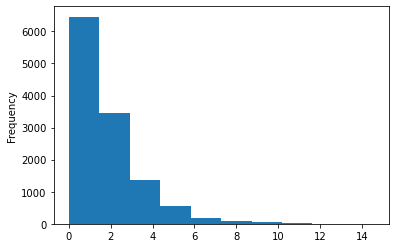

In [26]:
divafull.SDIKEHGHT.plot.hist()

In [8]:
#run options
rcp = 'rcp45'
p = '50p'

### assemble full dataset:
fuldat = pd.read_csv(ciamOutDir+'ciam-output-'+rcp+'_'+p+'_full.csv')
fuldat = fuldat.set_index('Unnamed: 0')

segs = fuldat.index.get_level_values(0).unique()

fuldat['popdens'] = np.nan
fuldat['waveclim'] = np.nan

wcdict = {'0':0,'1':1.25,'2':3,'3':4.25,'4':5.75,'5':6.5}

#loop over segments and assemble data
for s in segs:
    
    #translate waveclim category to category mean height (m)
    wc = wcdict[str(int(divafull[divafull.SEGID == int(re.findall("\d+", s)[0])].WAVECLIM.values[0]))]
    fuldat.at[s,'waveclim'] = wc
    fuldat.at[s,'popdens'] = divafull[divafull.SEGID == int(re.findall("\d+", s)[0])].POPDENS.values[0]

fuldat.to_csv(ciamOutDir+'ciam-output-'+rcp+'_'+p+'_full.csv')    

In [41]:
fuldat.to_csv(ciamSaveDir+'ciam-output-'+rcp+'_'+p+'_full.csv')

### inspect results / sanity check



In [163]:
rcp='rcp26'
p='50p'
fuldat = pd.read_csv(ciamOutDir+'ciam-output-'+rcp+'_'+p+'_full.csv')
fuldat = fuldat.set_index('Unnamed: 0')

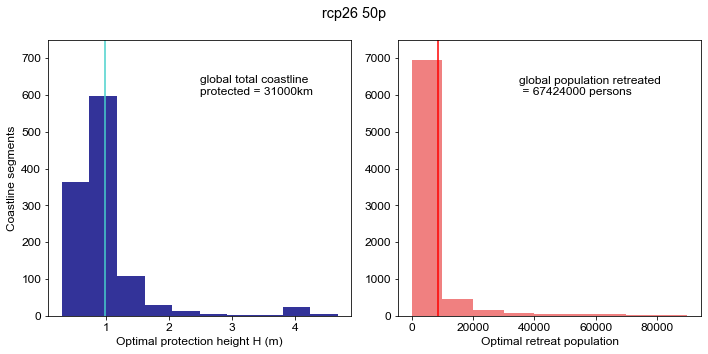

In [164]:
### plot
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 12

fig,axs = plt.subplots(1,2,figsize=(10,5))

hs=fuldat[fuldat['optA']=='fullProtect'].value.plot.hist(color='navy',alpha=0.8,ax=axs[0])
hs.set_xlabel('Optimal protection height H (m)')
hs.set_ylabel('Coastline segments')
axs[0].set_ylim(0,750)
axs[0].vlines(fuldat[fuldat['optA']=='fullProtect'].value.mean(),axs[0].get_ylim()[0],axs[0].get_ylim()[1],color='mediumturquoise')
annstr = 'global total coastline \nprotected = ' + str(int(np.round(fuldat[fuldat['optA']=='fullProtect'].L.sum(),-3))) + 'km'
axs[0].text(0.5,0.8,annstr,transform=axs[0].transAxes)

hs=fuldat[fuldat['optA']=='fullRetreat'].value.plot.hist(bins=np.arange(0,10**5,10**4),logx=False,color='lightcoral',ax=axs[1])
#hs.set_xlim(0,1000000)
hs.set_xlabel('Optimal retreat population')
hs.set_ylabel('')
axs[1].set_ylim(0,7500)
axs[1].vlines(fuldat[fuldat['optA']=='fullRetreat'].value.mean(),axs[1].get_ylim()[0],axs[1].get_ylim()[1],color='red')

annstr = 'global population retreated\n = ' + str(int(np.round(fuldat[fuldat['optA']=='fullRetreat'].value.sum(),-3))) + ' persons'
axs[1].text(0.4,0.8,annstr,transform=axs[1].transAxes)

fig.suptitle(rcp + ' ' + p)
plt.tight_layout()

### plot Figure S1a-b

<ipython-input-165-dd8f4072b53c>:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pldt = fuldatsub[(fuldat['optA']=='fullProtect')]
<ipython-input-165-dd8f4072b53c>:28: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb=plt.colorbar(m,cax=cax,cmap=cmap,ax=ax)
<ipython-input-165-dd8f4072b53c>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pldt = fuldatsub[(fuldat['optA']=='fullRetreat') & (fuldat['value']>1)]
<ipython-input-165-dd8f4072b53c>:41: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb=plt.colorbar(m,cmap=cmap,cax=cax,ax=ax)


Text(0.5, 0.98, 'rcp26 50p')

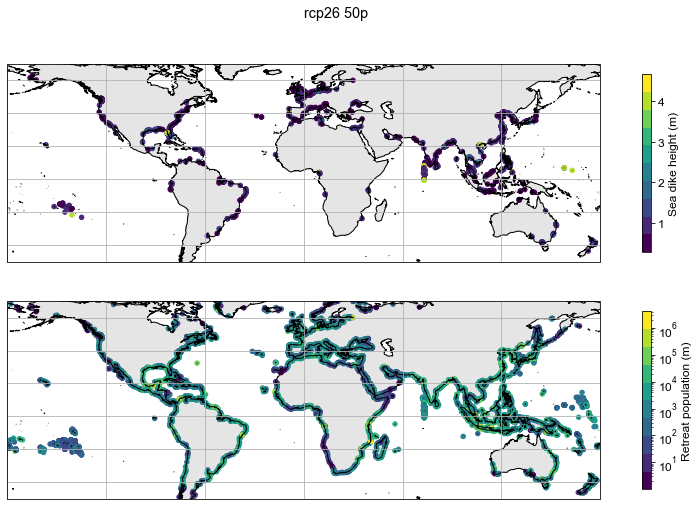

In [165]:
import cartopy.crs as ccrs
import cartopy
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 12
from mpl_toolkits.axes_grid1 import make_axes_locatable

pad = 0.05
shrink =0.9

extent = [-179, 179, -50, 70]
fuldatsub = fuldat[(fuldat.lon>extent[0]) & (fuldat.lon<extent[1]) & (fuldat.lat>extent[2]) & (fuldat.lat<extent[-1])]
cmap = matplotlib.cm.get_cmap('viridis', 10)


fig = plt.figure(figsize=(15,8))

## protect height
ax = fig.add_subplot(2,1,1,projection= ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND,facecolor='grey',alpha=0.2)

pldt = fuldatsub[(fuldat['optA']=='fullProtect')]
m=ax.scatter(pldt.lon,pldt.lat,c=pldt.value,s=20,cmap=cmap,transform=ccrs.PlateCarree())
ax.gridlines()
ax.coastlines(resolution='50m')
cax,kw = matplotlib.colorbar.make_axes(ax,pad=pad,shrink=shrink)
cb=plt.colorbar(m,cax=cax,cmap=cmap,ax=ax)
cb.set_label('Sea dike height (m)')

## retreat pop
ax = fig.add_subplot(2,1,2,projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND,facecolor='grey',alpha=0.2)

pldt = fuldatsub[(fuldat['optA']=='fullRetreat') & (fuldat['value']>1)]
m=ax.scatter(pldt.lon,pldt.lat,c=pldt.value,s=20,cmap=cmap,transform=ccrs.PlateCarree(),norm=matplotlib.colors.LogNorm(),)
ax.gridlines()
ax.coastlines(resolution='50m')
cax,kw = matplotlib.colorbar.make_axes(ax,pad=pad,shrink=shrink)
cb=plt.colorbar(m,cmap=cmap,cax=cax,ax=ax)

# resize_colorbar = get_resize_event_function(ax, cax)
# fig.canvas.mpl_connect('resize_event', resize_colorbar)
cb.set_label('Retreat population (m)')

fig.suptitle(rcp + ' ' + p)


### zoom in an a region of interest using this code

<ipython-input-166-be9b8a1778eb>:27: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb=plt.colorbar(m,cax=cax,cmap=cmap,ax=ax)
<ipython-input-166-be9b8a1778eb>:40: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb=plt.colorbar(m,cmap=cmap,cax=cax,ax=ax)


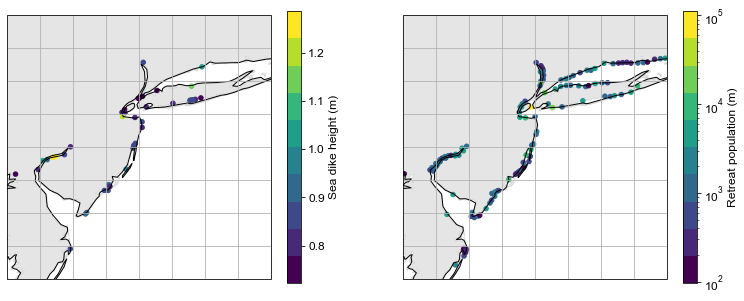

In [166]:
import cartopy.crs as ccrs
import cartopy
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 12

extent = [-76, -72, 38, 42]
fuldatsub = fuldat[(fuldat.lon>extent[0]) & (fuldat.lon<extent[1]) & (fuldat.lat>extent[2]) & (fuldat.lat<extent[-1])]
cmap = matplotlib.cm.get_cmap('viridis', 10)

#fig,axs = plt.subplots(2,1,figsize=(15,10))

#central_lon, central_lat = -70, 45

fig, axs = plt.subplots(1,2,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(13,10))

ax=axs[0]
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND,facecolor='grey',alpha=0.2)

pldt = fuldatsub[(fuldatsub['optA']=='fullProtect')]
m=ax.scatter(pldt.lon,pldt.lat,c=pldt.value,s=20,cmap=cmap,transform=ccrs.PlateCarree())
ax.gridlines()
ax.coastlines(resolution='50m')
pldt=fuldat[fuldat['optA']=='fullProtect']
cax,kw = matplotlib.colorbar.make_axes(ax,pad=0.05,shrink=0.5)
cb=plt.colorbar(m,cax=cax,cmap=cmap,ax=ax)
cb.set_label('Sea dike height (m)')

ax=axs[1]
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND,facecolor='grey',alpha=0.2)

pldt = fuldatsub[(fuldatsub['optA']=='fullRetreat') & (fuldatsub['value']>1)]
m=ax.scatter(pldt.lon,pldt.lat,c=pldt.value,s=20,cmap=cmap,transform=ccrs.PlateCarree(),norm=matplotlib.colors.LogNorm(),)
ax.gridlines()
ax.coastlines(resolution='50m')
pldt=fuldat[fuldat['optA']=='fullProtect']
cax,kw = matplotlib.colorbar.make_axes(ax,pad=0.05,shrink=0.5)
cb=plt.colorbar(m,cmap=cmap,cax=cax,ax=ax)
cb.set_label('Retreat population (m)')



### plot Figure S1c-f
boxplot of pop den, SLR, for retreat vs dike vs no adaptation


In [161]:
prot = fuldat[(fuldat['optA']=='fullProtect')]
ret = fuldat[(fuldat['optA']=='fullRetreat') & (fuldat['value']>1)]
noad = fuldat[(fuldat['optA']!='fullRetreat') & (fuldat['optA']!='fullProtect')]

noad.at[noad.popdens==0,'popdens'] = 1e-1
ret.at[ret.popdens==0,'popdens'] = 1e-1
prot.at[prot.popdens==0,'popdens'] = 1e-1


C:\Users\corey\anaconda3\envs\geo_scipy\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\corey\anaconda3\envs\geo_scipy\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\corey\anaconda3\envs\geo_scipy\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

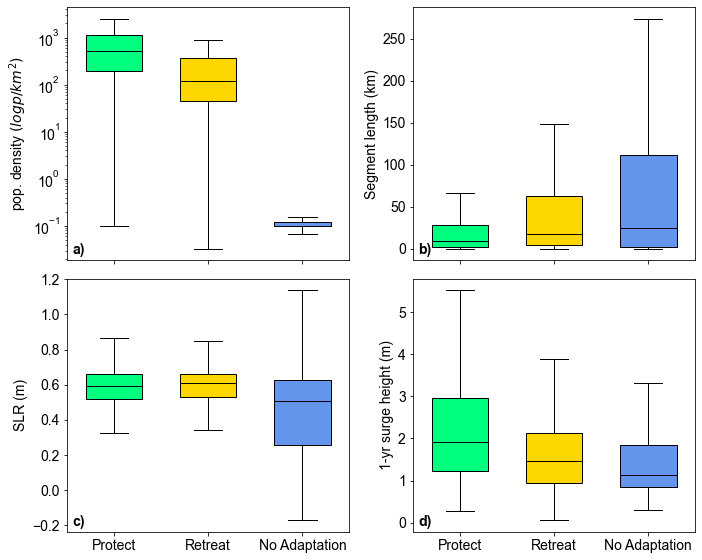

In [167]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from matplotlib import colors

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 14


axs = []
fig = plt.figure(figsize=(10,8))
spec = gridspec.GridSpec(ncols=2, nrows=2)
axs.append(fig.add_subplot(spec[0, 0]))
axs.append(fig.add_subplot(spec[0, 1]))
axs.append(fig.add_subplot(spec[1, 0]))
axs.append(fig.add_subplot(spec[1, 1]))


colors=['springgreen','gold','cornflowerblue']

vs = ['popdens','L','slr','s1']
labs = [r'pop. density $(log p/km^{2})$','Segment length (km)','SLR (m)','1-yr surge height (m)']
lets = ['a)','b)','c)','d)']

for i,v in enumerate(vs):
    ax = axs[i]
    bp = ax.boxplot([prot[v],ret[v],noad[v].dropna()],positions=[1,2,3],widths=0.6,patch_artist=True,medianprops=dict(color='black'),showfliers=False)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(1)
    if i==0: ax.set_yscale('log')
    #ax.set_ylim(1e-2,1e4)
    if i>1: ax.set_xticklabels(['Protect','Retreat','No Adaptation'])
    else: ax.set_xticklabels([])
    ax.set_ylabel(labs[i])
    ax.text(0.02,0.025,lets[i],transform=ax.transAxes,fontsize=14,fontweight='bold')


plt.tight_layout()